# Here we start Task 2  TFIDF

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pickle
import openpyxl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,6)

In [6]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_text
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import label_binarize
from sklearn import svm

# Dataset loading and adjusting

In [7]:
final_df = pd.read_excel('data/final_tm_df.xlsx')
del final_df['LDA_12']
del final_df['Author']



### Sets split

In [8]:
#we separate our data into training and test
df_test, df_train = train_test_split(final_df, test_size=0.7, random_state=420)

df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=420)

Y_train = df_train['Mayor Parties']
X_train = df_train.iloc[:,2:-2]

Y_test = df_test['Mayor Parties']
X_test = df_test.iloc[:,2:-2]

Y_val = df_val['Mayor Parties']
X_val = df_val.iloc[:,2:-2]

print(f"Len train: {len(X_train)}")
print(f"Len test: {len(X_test)}")
print(f"Len validation: {len(X_val)}")

Len train: 6832
Len test: 1463
Len validation: 1464


### Scaling the data

In [9]:
#we will first scale our data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Data dimensionality reduction

### Visualizing our data to identify features and clusters

#### Principal Component Analysis visualization

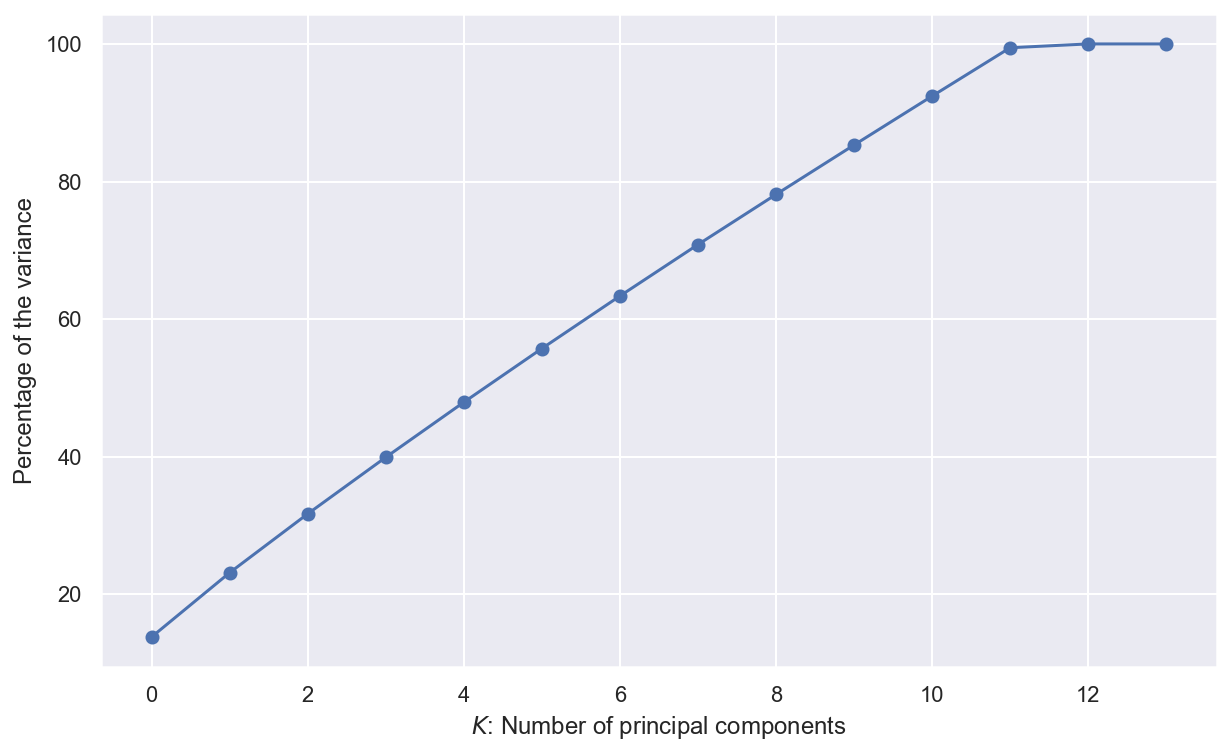

In [10]:
#we check how some dimensionality reduction techniques work
pca = PCA(n_components=X_train.shape[1]).fit(X_train)
eigenvalues = pca.explained_variance_


data_variance = np.sum(np.var(X_train,0))

plt.figure()
plt.plot(100*np.cumsum(eigenvalues)/data_variance, 'o-', label='Evolution eigenvalues')
plt.xlabel('$K$: Number of principal components')
plt.ylabel('Percentage of the variance')
plt.show()

#Most of the variance is explained by most of the components except the last two and the ammount of 
# variance explained by each of these other components is almost the same
# As we have very few variables a dimensionality reduction technique might not be very convenient.
# These two reasons make for our decision of not

In [ ]:
#We are still going to plot the two most relevant dimensions of the PCA transformed data 
#to see if we can identify some 

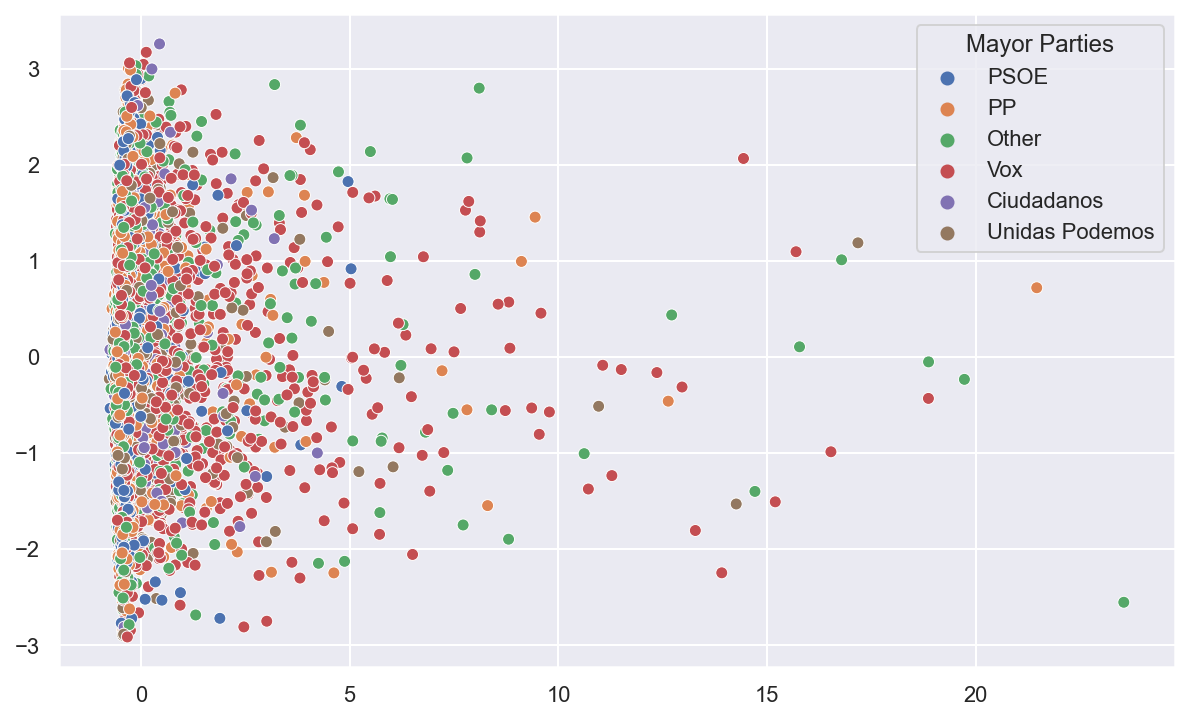

In [11]:
p_train = pca.transform(X_train)
sns.scatterplot(x = p_train[:,0], y = p_train[:,1] , hue = Y_train)
plt.show()

#### T-Distributed Stochastic Neighbor Embedding visualization

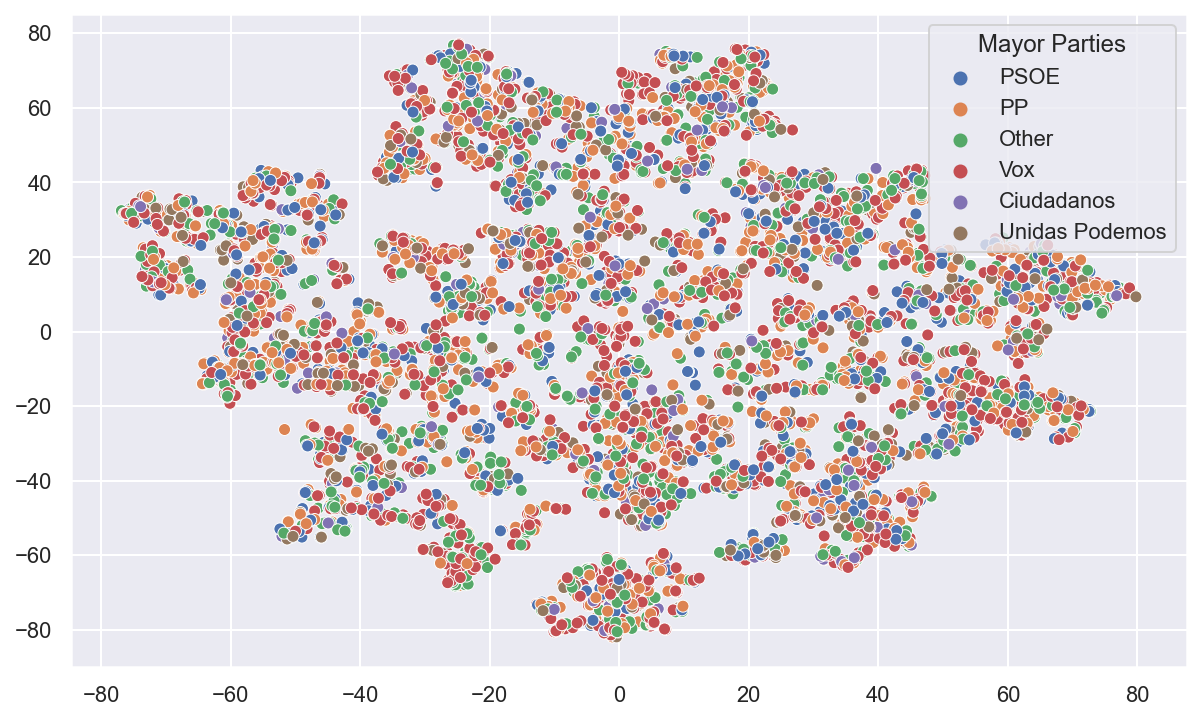

In [12]:
from sklearn.manifold import TSNE
p_train = TSNE(n_components=2).fit_transform(X_train)

sns.scatterplot(x = p_train[:,0], y = p_train[:,1] , hue = Y_train)
plt.show()

### Checking the accuracy with SVM

#### Defining our evaluating function

In [13]:
def SVM_accuracy_evolution(X_train_t, Y_train, X_val_t, Y_val, X_test_t, Y_test, rang_feat):
    """Compute the accuracy of training, validation and test data for different the number of features

    Args:
        X_train_t (numpy dnarray): training data projected in the new feature space (number data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number data x 1).
        X_val_t (numpy dnarray): validation data projected in the new feature space (number data x number dimensions).
        Y_val (numpy dnarray): labels of the validation data (number data x 1).
        X_test_t (numpy dnarray): test data projected in the new feature space (number data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number data x 1).                                     
        rang_feat: range with different number of features to be evaluated 
    """
    
    # Define the model to train a liner SVM
    clf = svm.SVC(kernel='linear')
    
    acc_tr = np.empty(X_train_t.shape[1]-1)
    acc_val = np.empty(X_train_t.shape[1]-1)
    acc_test = np.empty(X_train_t.shape[1]-1)
    for i in rang_feat:
        # Train SVM classifier
        clf.fit(X_train_t[:,:i], Y_train)

        # Compute train, val and test accuracies and save in acc_tr, acc_val and acc_test
        acc_tr[i-1] =  clf.score(X_train_t[:,:i], Y_train)
        acc_val[i-1] = clf.score(X_val_t[:,:i], Y_val)
        acc_test[i-1] = clf.score(X_test_t[:,:i], Y_test)

    return acc_tr, acc_val,acc_test

#### Evaluating PCA

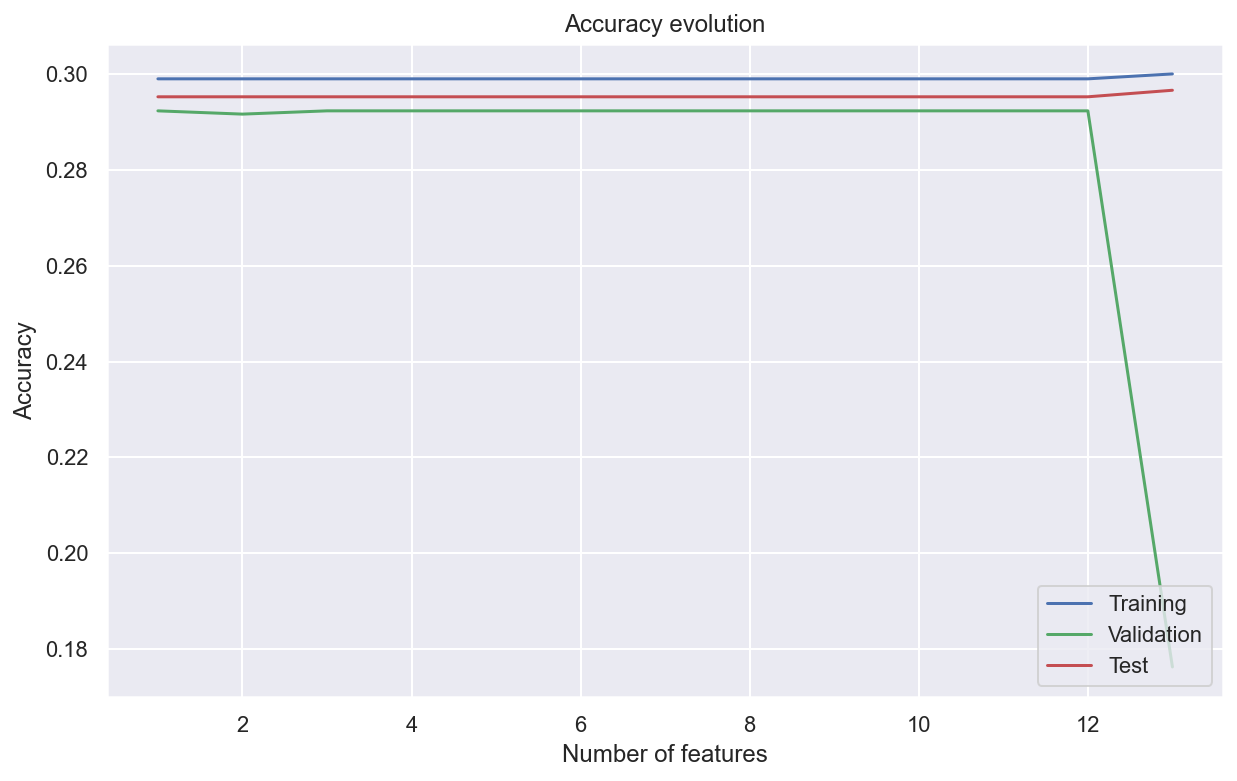

In [21]:
P_train = pca.transform(X_train)
P_test = pca.transform(X_test)
P_val = pca.transform(X_val)
N_feat_max = X_train.shape[1]

rang_feat = np.arange(1, N_feat_max, 1)
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(P_train, 
                                                     Y_train, 
                                                     P_val, 
                                                     Y_val, 
                                                     P_test,
                                                     Y_test, rang_feat)

plt.figure()
plt.plot(range(1,P_train.shape[1]), acc_tr, "b", label="train")
plt.plot(range(1,P_train.shape[1]), acc_val, "g", label="val")
plt.plot(range(1,P_train.shape[1]), acc_test, "r", label="test")

plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title('Accuracy evolution')
plt.legend(['Training', 'Validation', 'Test'], loc = 4)
plt.show()

#### Evaluating CCA 

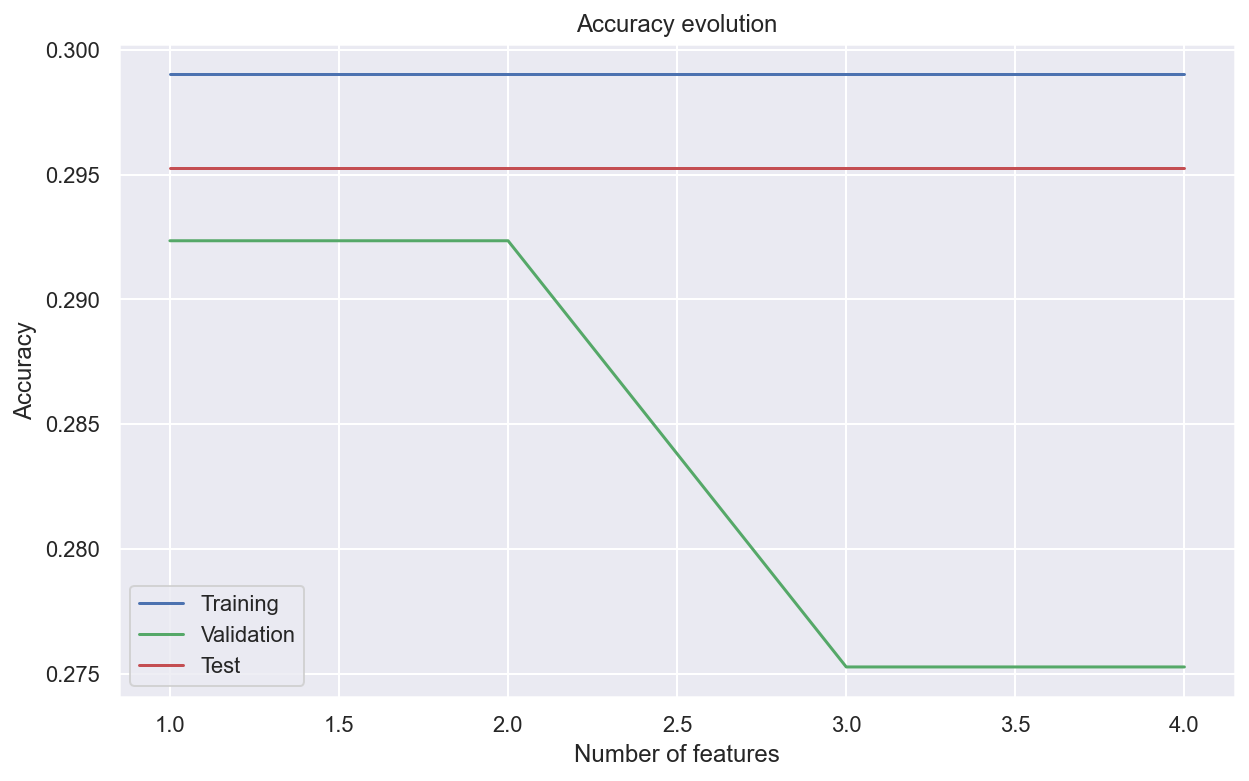

Number optimum of features: 1
The optimum test accuracy is 29.52836637047163


In [24]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import label_binarize
Y_train_bin = label_binarize(Y_train, classes=list(Y_train.unique()))
N_feat_max = Y_train.unique().size-1
cca = CCA(n_components=N_feat_max)
cca.fit(X_train, Y_train_bin)

P_train_cca = cca.transform(X_train)
P_test_cca = cca.transform(X_test)
P_val_cca = cca.transform(X_val)

rang_feat = np.arange(1, N_feat_max, 1)
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(P_train_cca, 
                                                     Y_train, 
                                                     P_val_cca, 
                                                     Y_val, 
                                                     P_test_cca,
                                                     Y_test, rang_feat)

plt.figure()
plt.plot(range(1, P_train_cca.shape[1]), acc_tr, "b", label="train")
plt.plot(range(1, P_train_cca.shape[1]), acc_val, "g", label="val")
plt.plot(range(1, P_train_cca.shape[1]), acc_test, "r", label="test")



plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title('Accuracy evolution')
plt.legend(['Training', 'Validation','Test'])
plt.show()

pos_max = np.argmax(acc_test)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]

print(f'Number optimum of features: {num_opt_feat}')
print(f"The optimum test accuracy is {100*test_acc_opt}")

#### Evaluating Kernel PCA

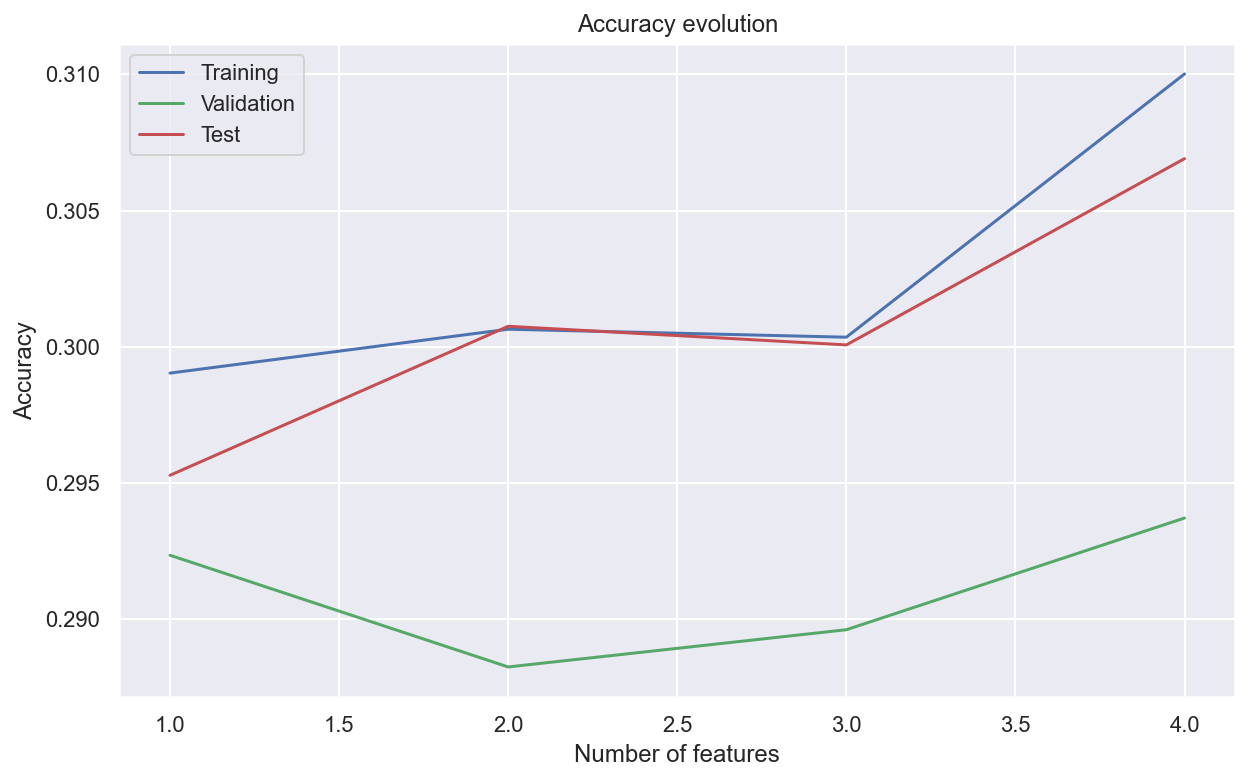

Number optimum of features: 4
The optimum test accuracy is 30.69036226930964


In [37]:
from sklearn.decomposition import KernelPCA

Y_train_bin = label_binarize(Y_train, classes=list(Y_train.unique()))

N_feat_max = Y_train.unique().size-1


kpca = KernelPCA(n_components=N_feat_max, kernel='rbf', gamma=1)
kpca.fit(X_train, Y_train_bin)


P_train_kpca = kpca.transform(X_train)
P_test_kpca = kpca.transform(X_test)
P_val_kpca = kpca.transform(X_val)

rang_feat = np.arange(1, N_feat_max, 1)
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(P_train_kpca, 
                                                     Y_train, 
                                                     P_val_kpca, 
                                                     Y_val, 
                                                     P_test_kpca,
                                                     Y_test, rang_feat)

plt.figure()
plt.plot(range(1, P_train_kpca.shape[1]), acc_tr, "b", label="train")
plt.plot(range(1, P_train_kpca.shape[1]), acc_val, "g", label="val")
plt.plot(range(1, P_train_kpca.shape[1]), acc_test, "r", label="test")



plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title('Accuracy evolution')
plt.legend(['Training', 'Validation','Test'])
plt.show()

pos_max = np.argmax(acc_test)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]

print(f'Number optimum of features: {num_opt_feat}')
print(f"The optimum test accuracy is {100*test_acc_opt}")


In [ ]:
# IMPORTANTE as we have very few variables a dimensionality reduction technique might not be very convenient

In [ ]:
# the accuracy is not high enough to give a good confidence on future data


In [25]:
#as our models are not performing very well (probably due to the nature of our data)
# the model that we are going to choose is a decision tree

## the reasons
# it wont perform as good (as bad really) as random forest or other 
# classification techniques that we already have tried
# BUT those techniques haven't work with a good performance so.
# The most important part of our proyect is interpretability and beaing able to extract knowledge from the data
# that is why a decision tree will serve us good
# it doesnt rely on scaling the data (so we can let untouched our likes and retweets and see 
# if they take part on the classification decision)
# and, if we dont do linearn combinations of our data (that means no PCA), 
# we will have rules that apply over likes, retweets and the probability values of our selected topics 
# returned by the LDA which are features that we know well how to interpret.
# a Decision tree's criterion for creating branches acts as an embedded feature selector 

#we will reload our data 
Y_train = df_train['Mayor Parties']
X_train = df_train.iloc[:,2:-2]

Y_test = df_test['Mayor Parties']
X_test = df_test.iloc[:,2:-2]

Y_val = df_val['Mayor Parties']
X_val = df_val.iloc[:,2:-2]

# Decision Tree classifier

In [27]:
max_depth = range(2,14)
criterion = ['gini', 'entropy']
clf_GS = GridSearchCV(estimator = DecisionTreeClassifier(), 
                      param_grid = {'criterion':criterion,'max_depth':max_depth},
                      n_jobs = -1)
clf_GS.fit(X_train, Y_train)

print(clf_GS.best_score_)
print(clf_GS.best_params_)

tree_classifier = DecisionTreeClassifier(**clf_GS.best_params_).fit(X_train,Y_train)
print(f'Accuracy on trainset: {tree_classifier.score(X_train,Y_train)}')
print(f'Accuracy on testset: {tree_classifier.score(X_test,Y_test)}')

0.337677165480833
{'criterion': 'entropy', 'max_depth': 3}
Accuracy on trainset: 0.343384074941452
Accuracy on testset: 0.32809295967190705


In [28]:
print(export_text(tree_classifier, feature_names=list(final_df.columns[2:-2])))

|--- Likes <= 50.50
|   |--- Likes <= 2.50
|   |   |--- Retweets <= 1.50
|   |   |   |--- class: Other
|   |   |--- Retweets >  1.50
|   |   |   |--- class: PP
|   |--- Likes >  2.50
|   |   |--- Likes <= 17.50
|   |   |   |--- class: PP
|   |   |--- Likes >  17.50
|   |   |   |--- class: Vox
|--- Likes >  50.50
|   |--- Retweets <= 549.50
|   |   |--- Retweets <= 28.50
|   |   |   |--- class: Vox
|   |   |--- Retweets >  28.50
|   |   |   |--- class: Vox
|   |--- Retweets >  549.50
|   |   |--- Likes <= 2632.00
|   |   |   |--- class: Vox
|   |   |--- Likes >  2632.00
|   |   |   |--- class: Vox



In [ ]:
# we now see that the tree does not explain anything it only takes the likes and retweets
# so we will repeat without them


In [29]:
max_depth = range(2,14)
criterion = ['gini', 'entropy']
clf_GS = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = {'criterion':criterion,'max_depth':max_depth},
    n_jobs = -1
)
clf_GS.fit(X_train.iloc[:,:-2], Y_train)

print(clf_GS.best_score_)
print(clf_GS.best_params_)

tree_classifier = DecisionTreeClassifier(**clf_GS.best_params_).fit(X_train.iloc[:,:-2],Y_train)
print('Accuracy on trainset: ',tree_classifier.score(X_train.iloc[:,:-2],Y_train))
print('Accuracy on testset: ',tree_classifier.score(X_test.iloc[:,:-2],Y_test))

0.29844879458390144
{'criterion': 'entropy', 'max_depth': 2}
Accuracy on trainset:  0.3004976580796253
Accuracy on testset:  0.29049897470950103


In [30]:
print(export_text(tree_classifier, feature_names=list(final_df.columns[2:-4])))

|--- Congratulations and culture <= 0.06
|   |--- Evolution of the vaccination plan and pandemic situation <= 0.02
|   |   |--- class: Other
|   |--- Evolution of the vaccination plan and pandemic situation >  0.02
|   |   |--- class: Vox
|--- Congratulations and culture >  0.06
|   |--- Madrid elections (citizen participation) <= 0.06
|   |   |--- class: Vox
|   |--- Madrid elections (citizen participation) >  0.06
|   |   |--- class: Vox



In [ ]:
# We see that it only classifies for Vox and PSOE#

In [ ]:
# after all we conclude that due to the nature of our dataset, a classification task 
# of predicting to which party a tweet belongs is not an easy task and probably 
# not the most enlightening question to make.